<div class="alert alert-block alert-success">
    <h1>
        Example notebook - CiteAb antibody data
    </h1>
    <p>
        Link to dataset : <a href="">insert link</a>
    </p>
</div>

# Import modules and functions

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import time

from turingdb_examples.graph import (
    build_create_command_from_networkx,
    split_cypher_commands
)

In [2]:
%load_ext autoreload
%autoreload 2

# Check data files are available

In [3]:
example_name = "citeab_antibody"
path_data = f"{os.getcwd()}/data/{example_name}"
if not os.path.exists(path_data):
    raise ValueError(f"{path_data} does not exists")

filename = "CiteAb_HER2_p53_Sample_Antibody_Citations_Aug2025.xlsx"
list_csv_files = sorted(os.listdir(path_data))
if filename not in list_csv_files:
    raise ValueError(
        f"{filename} csv file is not available in {path_data}"
    )

# Import and format data

In [4]:
df = pd.read_excel(f"{path_data}/{filename}")

# Drop rows only containing NaN values
old_shape = len(df)
df = df.dropna(axis=0, how="all")
print(f"Dropped {old_shape - len(df)} rows only containing NaN values")

# Drop columns only containing NaN values
old_shape = df.shape[1]
df = df.dropna(axis=1, how="all")
print(f"Dropped {old_shape - df.shape[1]} columns only containing NaN values")

# Remove rows with NaN values in "citeabid" and "protein_code" columns, and "protein_code" being "not_applicable"
old_shape = df.shape[1]
df = df[df["citeabid"].notna() & df["protein_code"].notna() & (df["protein_code"] != "not_applicable")]
print(f"Dropped {old_shape - df.shape[1]} columns containing NaN values in 'citeabid' and 'protein_code' columns")

# Remove columns only containing "not_applicable"
old_shape = df.shape[1]
df = df.drop(list((df != "not_applicable").sum()[(df != "not_applicable").sum() == 0].index), axis=1)
print(f"Dropped {old_shape - df.shape[1]} columns only containing 'not_applicable'")

df

Dropped 0 rows only containing NaN values
Dropped 4 columns only containing NaN values
Dropped 0 columns containing NaN values in 'citeabid' and 'protein_code' columns
Dropped 3 columns only containing 'not_applicable'


,citeabid,name,code,company,discontinued,host,clonality,clone,conjugate,protein_code,...,published_date,author_list,last_author,citation_applications,citation_reactants,citation_reactant_ncbi_ids,unique_flow_conjugates_count,instruments,ncbi_gene_id,gene_name
0,2390688,c-erbB-2 Oncoprotein,A0485,Dako,Discontinued,Rabbit,Polyclonal,not_applicable,Unconjugated,P04626,...,2018-08-13,"Atif Ali Hashmi, Raeesa Mahboob, Saadia Mehmoo...",Muhammad Muzzammil Edhi,IHC,Homo sapiens (Human),9606,NaN,NaN,2064,ERBB2
1,1026763,HER2/ErbB2 Rabbit pAb,A2071,ABclonal,NaN,Rabbit,Polyclonal,not_applicable,NaN,P04626,...,2020-05-05,"Chongshu Jian, Jiajun Fu, Xu Cheng, Li-jun She...",Hongliang Li,WB,Mus musculus (Mouse),10090,NaN,NaN,2064,ERBB2
2,818617,Neu Antibody (C-18),sc-284,Santa Cruz Biotechnology,Discontinued,Rabbit,Polyclonal,not_applicable,NaN,P04626,...,2011-04-01,"Radwan N Safa, Xu-Yang Peng, Laura Pentassugli...",Douglas B Sawyer,WB,NaN,NaN,NaN,NaN,2064,ERBB2
3,4634354,Human anti ErbB2 (Trastuzumab Biosimilar),MCA6092,Bio-Rad (Formerly AbD Serotec),NaN,Human,Monoclonal,4D5-8,Unconjugated,P04626,...,2021-11-09,"Wei He, Angela C Evans, W F Hynes, Matthew A C...",C Robertson,NaN,Homo sapiens (Human),9606,NaN,NaN,2064,ERBB2
4,818617,Neu Antibody (C-18),sc-284,Santa Cruz Biotechnology,Discontinued,Rabbit,Polyclonal,not_applicable,NaN,P04626,...,2020-03-02,"Stefano Annunziato, Catrin Lutz, Linda Hennema...",Jos Jonkers,NaN,NaN,NaN,NaN,NaN,2064,ERBB2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,820814,p53 Antibody (DO-1),sc-126,Santa Cruz Biotechnology,NaN,Mouse,Monoclonal,DO-1,'Many Available',P04637,...,2021-02-25,"Wei Zhou, Weiyang Lou, Junru Chen, Bisha Ding,...",Donghai Jiang,WB,Homo sapiens (Human),9606,NaN,NaN,7157,TP53
1996,820815,p53 Antibody (FL-393),sc-6243,Santa Cruz Biotechnology,Discontinued,Rabbit,Polyclonal,not_applicable,Unconjugated,P04637,...,2007-08-01,"Ling Zhu, Ellen A Rorke, Richard L Eckert",Richard L Eckert,NaN,NaN,NaN,NaN,NaN,7157,TP53
1997,2390686,p53 Protein (Concentrate),M7001,Dako,NaN,Mouse,Monoclonal,DO-7,Unconjugated,P04637,...,2015-12-25,"Seiichi Daikuhara, Takeshi Uehara, Kayoko Higu...",Hiroyoshi Ota,NaN,NaN,NaN,NaN,NaN,7157,TP53
1998,123515,p53 (1C12) Mouse mAb,2524,Cell Signaling Technology,NaN,Mouse,Monoclonal,1C12G11A1E8B1,Unconjugated,P04637,...,2019-11-05,"Bing Deng, Wenli Xu, Zelin Wang, Chang Liu, Pe...",Lianghu Qu,NaN,NaN,NaN,NaN,NaN,7157,TP53


In [5]:
# Basic info
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nData types and missing values:")
df_summary = pd.concat([df.dtypes, df.isnull().sum()], axis=1)
df_summary.columns = ["dtypes", "nb_NaNs"]
print(df_summary)

Dataset shape: (2000, 48)

Column names:
['citeabid', 'name', 'code', 'company', 'discontinued', 'host', 'clonality', 'clone', 'conjugate', 'protein_code', 'target', 'species', 'recombinant', 'primary', 'modification', 'modification_site', 'company_applications', 'company_reactants', 'company_validation_methods', 'publication_type', 'citeab_publication_id', 'pubmedid', 'pprid', 'has_pubmed_version', 'journal', 'journal_impact', 'cited_by_count', 'published_year', 'continent', 'country', 'institution', 'institution_industry', 'affiliation', 'research_area', 'disease_areas', 'disease_states', 'disease_state_mesh_uids', 'title', 'published_date', 'author_list', 'last_author', 'citation_applications', 'citation_reactants', 'citation_reactant_ncbi_ids', 'unique_flow_conjugates_count', 'instruments', 'ncbi_gene_id', 'gene_name']

Data types and missing values:
                               dtypes  nb_NaNs
citeabid                        int64        0
name                           object  

In [6]:
# Summary statistics
print("\nNumerical columns summary:")
display(df.describe())

print("\nCategorical columns value counts:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols[:5]:  # First 5 categorical columns
    print(100 * "-")
    print(df[col].value_counts().head(10))


Numerical columns summary:


,citeabid,citeab_publication_id,pubmedid,journal_impact,cited_by_count,published_year
count,2.000000e+03,2.000000e+03,1.880000e+03,1871.000000,751.000000,2000.0000
mean,1.071082e+06,1.743067e+07,2.939552e+07,5.271647,42.227696,2017.4635
std,1.561249e+06,1.618792e+07,6.685022e+06,4.226359,65.393639,5.3823
min,8.132900e+04,7.240000e+02,7.977649e+06,0.000000,1.000000,1994.0000
25%,1.241600e+05,1.907616e+06,2.523670e+07,2.803000,10.000000,2015.0000
50%,7.436680e+05,4.937282e+06,3.004804e+07,4.176000,22.000000,2019.0000
75%,8.208200e+05,3.387120e+07,3.455876e+07,5.932000,48.000000,2021.0000
max,1.720776e+07,4.010819e+07,4.060512e+07,34.026000,889.000000,2025.0000



Categorical columns value counts:
----------------------------------------------------------------------------------------------------
name
c-erbB-2 Oncoprotein                                   212
p53 Antibody (DO-1)                                    201
p53 (1C12) Mouse mAb                                    97
HER2/ErbB2 (29D8) Rabbit mAb                            88
Phospho-p53 (Ser15) Antibody                            77
Neu Antibody (C-18)                                     72
HER2/ErbB2 (D8F12) XP® Rabbit mAb                       66
p53 Antibody (FL-393)                                   65
Phospho-HER2/ErbB2 (Tyr1221/1222) (6B12) Rabbit mAb     60
p53 Antibody                                            57
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
code
A0485      212
sc-126     201
2524        97
2165        88
9284        77
sc-284      72
4290        66
sc-6243     65
2243        60
92

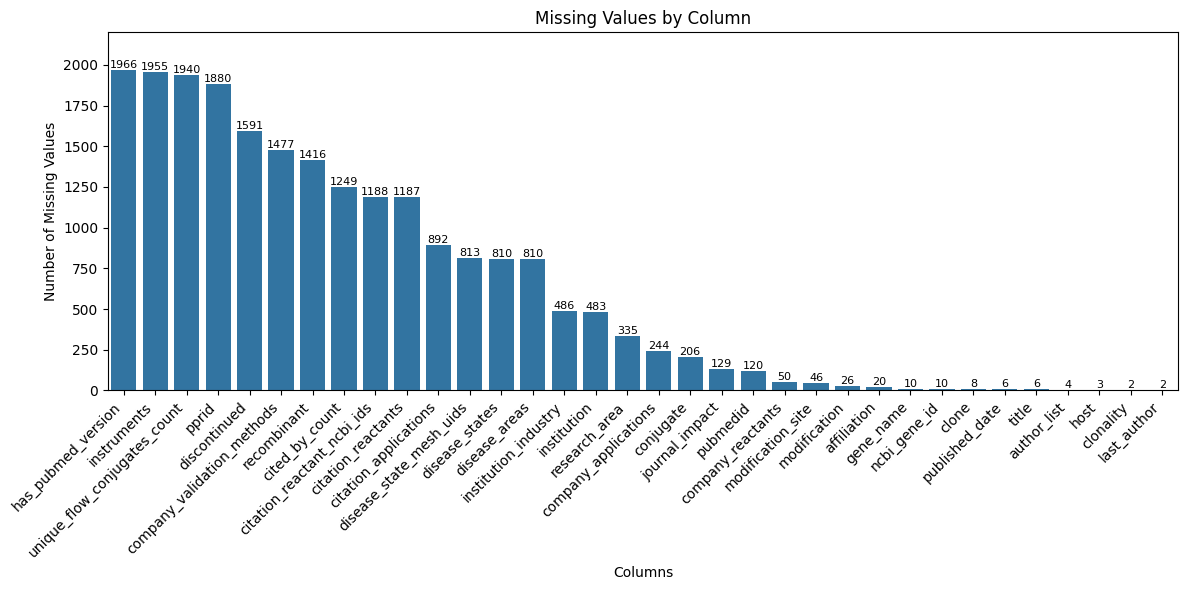

In [7]:
# Visualize missing data
plt.figure(figsize=(12, 6))
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
if not missing_data.empty:
    ax = sns.barplot(x=missing_data.index, y=missing_data.values)
    
    # Add count labels on top of bars
    for i, v in enumerate(missing_data.values):
        ax.text(i, v, str(v), ha='center', va='bottom', fontsize=8)
    
    plt.title('Missing Values by Column')
    plt.xlabel('Columns')
    plt.ylabel('Number of Missing Values')
    plt.ylim(0, 1.1 * len(df))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values in the dataset")

# Create graph from dataframe

In [8]:
# Function create_graph_from_df

from typing import Dict, List, Optional, Union, Tuple
import networkx as nx

def create_graph_from_df(
    df: pd.DataFrame,
    *,
    directed: bool = True,
    source_node_col: Union[str, Dict[str, str]] = 'source',
    target_node_col: Union[str, Dict[str, str]] = 'target',
    attributes_source_node_cols: Union[str, List[str], None] = None,
    attributes_target_node_cols: Union[str, List[str], None] = None,
    optional_nodes_cols: Optional[Dict[str, Dict[str, Union[str, List[str], bool]]]] = None,
    attributes_edges: Union[str, List[str], None] = None,
    edge_type_col: Optional[str] = None,
) -> Union[nx.Graph, nx.DiGraph]:
    """
    Create a NetworkX graph from a pandas DataFrame.
    
    This function converts a DataFrame where each row represents an interaction into a NetworkX graph.
    It handles complex scenarios with multiple node types, attributes, and relationships.
    
    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame where each row represents an interaction.
    
    directed : bool, default=True
        Whether to create a directed graph. If True, creates nx.DiGraph, otherwise nx.Graph.
    
    source_node_col : str or Dict[str, str], default='source'
        Column(s) specifying the source node. 
        If str: Name of column containing source node IDs.
        If dict: {
            'id': 'column_name',  # Required: Column containing node IDs
            'displayName': 'column_name',  # Optional: Column containing node labels
            'type': value  # Optional: Can be either:
                           # - A column name containing node types
                           # - A constant string value to use as the type for all nodes
        }
    
    target_node_col : str or Dict[str, str], default='target'
        Column(s) specifying the target node.
        Same format as source_node_col.
    
    attributes_source_node_cols : str, List[str], or None, default=None
        Column(s) containing attributes for source nodes.
    
    attributes_target_node_cols : str, List[str], or None, default=None
        Column(s) containing attributes for target nodes.
    
    optional_nodes_cols : Dict[str, Dict[str, Union[str, List[str], bool]]] or None, default=None
        Specifications for additional node sets in the DataFrame.
        Format: {
            'node_set_name': {
                'id': 'column_name',  # Required: Column containing node IDs
                'displayName': 'column_name',  # Optional: Column containing node labels
                'type': 'column_name',  # Optional: Column containing node types
                'attributes': ['col1', 'col2', ...],  # Optional: Columns for node attributes
                'link_to_source': True,  # Optional: Whether to link to source nodes
                'link_to_target': False,  # Optional: Whether to link to target nodes
                'edge_attributes': ['col1', 'col2', ...]  # Optional: Edge attribute columns
            },
            ...
        }
    
    attributes_edges : str, List[str], or None, default=None
        Column(s) containing edge attributes between source and target nodes.
    
    edge_type_col : str or None, default=None
        Column containing the type/label for edges.
    
    Returns
    -------
    G : nx.DiGraph or nx.Graph
        NetworkX graph with nodes, edges, and attributes as specified.
    
    Notes
    -----
    - Node IDs must be unique and not NaN
    - If label is not specified, node ID is used as label
    - Node attributes are added as node properties in the graph
    - Edge attributes are added as edge properties in the graph
    
    Examples
    --------
    >>> # Simple example with just source and target columns
    >>> G = create_graph_from_df(df, source_node_col='person', target_node_col='movie')
    
    >>> # Complex example with attributes and optional nodes
    >>> G = create_graph_from_df(
    ...     df,
    ...     source_node_col={'id': 'person_id', 'displayName': 'person_name', 'type': 'person_type'},
    ...     target_node_col={'id': 'movie_id', 'displayName': 'movie_title', 'type': 'movie_type'},
    ...     attributes_source_node_cols=['person_age', 'person_gender'],
    ...     attributes_target_node_cols=['movie_year', 'movie_genre'],
    ...     optional_nodes_cols={
    ...         'director': {
    ...             'id': 'director_id',
    ...             'displayName': 'director_name',
    ...             'attributes': ['director_age'],
    ...             'link_to_source': False,
    ...             'link_to_target': True
    ...         }
    ...     },
    ...     attributes_edges=['rating', 'watched_date'],
    ...     edge_type_col='interaction_type'
    ... )
    """
    import pandas as pd
    import numpy as np

    label_str = 'displayName'
    
    # Create a directed or undirected graph
    G = nx.DiGraph() if directed else nx.Graph()
    
    # Helper function to process node columns
    def process_node_info(col_spec):
        if isinstance(col_spec, str):
            return {'id': col_spec, label_str: None, 'type': None, 'is_type_column': False}
        else:
            # Check if 'type' is directly a string (constant type) or a column name
            type_value = col_spec.get('type')
            is_type_column = False
            
            # If type is specified and is a string that exists as a column, it's a column reference
            # Otherwise, it's treated as a constant value
            if (isinstance(type_value, str) and type_value in df.columns):
                is_type_column = True
                
            return {
                'id': col_spec.get('id'),
                label_str: col_spec.get(label_str),
                'type': type_value,
                'is_type_column': is_type_column
            }
    
    # Process node column specifications
    source_info = process_node_info(source_node_col)
    target_info = process_node_info(target_node_col)
    
    # Validate required columns exist in the DataFrame
    required_cols = [source_info['id'], target_info['id']]
    if source_info[label_str]:
        required_cols.append(source_info[label_str])
    if source_info['type'] and source_info['is_type_column']:
        required_cols.append(source_info['type'])
    if target_info[label_str]:
        required_cols.append(target_info[label_str])
    if target_info['type'] and target_info['is_type_column']:
        required_cols.append(target_info['type'])
    
    # Add attribute columns to required columns if specified
    if attributes_source_node_cols:
        if isinstance(attributes_source_node_cols, str):
            required_cols.append(attributes_source_node_cols)
        else:
            required_cols.extend(attributes_source_node_cols)
    
    if attributes_target_node_cols:
        if isinstance(attributes_target_node_cols, str):
            required_cols.append(attributes_target_node_cols)
        else:
            required_cols.extend(attributes_target_node_cols)
    
    if attributes_edges:
        if isinstance(attributes_edges, str):
            required_cols.append(attributes_edges)
        else:
            required_cols.extend(attributes_edges)
    
    if edge_type_col:
        required_cols.append(edge_type_col)
    
    # Check for optional node sets
    if optional_nodes_cols:
        for node_set, config in optional_nodes_cols.items():
            required_cols.append(config['id'])
            if label_str in config and config[label_str]:
                required_cols.append(config[label_str])
            #if 'type' in config and config['type']:
            #    required_cols.append(config['type'])
            if ('type' in config) and config['type'] and (config['type'] in df.columns):
                required_cols.append(config['type'])
            if 'attributes' in config and config['attributes']:
                if isinstance(config['attributes'], str):
                    required_cols.append(config['attributes'])
                else:
                    required_cols.extend(config['attributes'])
            if 'edge_attributes' in config and config['edge_attributes']:
                if isinstance(config['edge_attributes'], str):
                    required_cols.append(config['edge_attributes'])
                else:
                    required_cols.extend(config['edge_attributes'])
    
    # Check if all required columns exist in DataFrame
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns in DataFrame: {missing_cols}")
    
    # Helper function to normalize attributes to a list
    def normalize_attr(attr):
        if attr is None:
            return []
        elif isinstance(attr, str):
            return [attr]
        return list(attr)
    
    # Normalize attribute lists
    source_attrs = normalize_attr(attributes_source_node_cols)
    target_attrs = normalize_attr(attributes_target_node_cols)
    edge_attrs = normalize_attr(attributes_edges)
    
    # Function to add a node to the graph with its attributes
    def add_node_with_attrs(row, node_set, node_id_col, node_label_col, node_type_val, is_type_column, attr_cols, node_prefix=''):
        if pd.isna(row[node_id_col]):
            return None
        
        node_id = row[node_id_col]
        
        # Skip if node_id is NaN
        if pd.isna(node_id):
            return None
            
        # Add node if it doesn't exist yet
        if node_id not in G:
            # Set node attributes
            node_attrs = {}
            
            # Add label if specified
            if node_label_col:
                label = row[node_label_col] if not pd.isna(row[node_label_col]) else node_id
                node_attrs[label_str] = label
            else:
                node_attrs[label_str] = str(node_id)
            
            # Add type if specified
            if node_type_val is not None:
                if is_type_column:
                    # Type from column
                    node_type = row[node_type_val] if not pd.isna(row[node_type_val]) else None
                    if node_type:
                        node_attrs['type'] = node_type
                else:
                    # Type as constant value
                    node_attrs['type'] = node_type_val
            else:
                node_attrs['type'] = node_set
            
            # Add other attributes
            for attr_col in attr_cols:
                if attr_col in row and not pd.isna(row[attr_col]):
                    attr_name = f"{node_prefix}{attr_col}" if node_prefix else attr_col
                    node_attrs[attr_name] = row[attr_col]
            
            G.add_node(node_id, **node_attrs)
        
        return node_id
    
    # Process each row in the DataFrame
    for idx, row in df.iterrows():
        # Add source node
        source_id = add_node_with_attrs(
            row,
            source_info['type'],
            source_info['id'], 
            source_info[label_str], 
            source_info['type'],
            source_info['is_type_column'],
            source_attrs, 
            #node_prefix='source_'
        )
        
        # Add target node
        target_id = add_node_with_attrs(
            row,
            target_info['type'],
            target_info['id'], 
            target_info[label_str], 
            target_info['type'],
            target_info['is_type_column'],
            target_attrs, 
            #node_prefix='target_'
        )
        
        # Skip if either source or target is None
        if source_id is None or target_id is None:
            continue
            
        # Add edge between source and target with attributes
        edge_attributes = {}
        
        # Add edge type if specified
        if edge_type_col and edge_type_col in row and not pd.isna(row[edge_type_col]):
            edge_attributes['type'] = row[edge_type_col]
        
        # Add edge attributes
        for attr_col in edge_attrs:
            if attr_col in row and not pd.isna(row[attr_col]):
                edge_attributes[attr_col] = row[attr_col]
        
        G.add_edge(source_id, target_id, **edge_attributes)
        
        # Process optional node sets
        if optional_nodes_cols:
            for node_set, config in optional_nodes_cols.items():
                # Extract node information
                node_id_col = config['id']
                node_label_col = config.get(label_str)
                
                # Handle node type (column reference or constant value)
                node_type_val = config.get('type')
                is_type_column = False
                if isinstance(node_type_val, str) and node_type_val in df.columns:
                    is_type_column = True
                
                node_attr_cols = normalize_attr(config.get('attributes', []))
                
                # Add optional node
                opt_node_id = add_node_with_attrs(
                    row,
                    node_set,
                    node_id_col, 
                    node_label_col, 
                    node_type_val,
                    is_type_column, 
                    node_attr_cols, 
                    #node_prefix=f"{node_set}_"
                )
                
                if opt_node_id is None:
                    continue
                
                # Connect to source if specified
                if config.get('link_to_source', False) and source_id is not None:
                    edge_attrs_to_source = {}
                    
                    # Add edge attributes if specified
                    if 'edge_attributes' in config:
                        for attr_col in normalize_attr(config['edge_attributes']):
                            if attr_col in row and not pd.isna(row[attr_col]):
                                edge_attrs_to_source[attr_col] = row[attr_col]
                    
                    G.add_edge(source_id, opt_node_id, **edge_attrs_to_source)
                
                # Connect to target if specified
                if config.get('link_to_target', False) and target_id is not None:
                    edge_attrs_to_target = {}
                    
                    # Add edge attributes if specified
                    if 'edge_attributes' in config:
                        for attr_col in normalize_attr(config['edge_attributes']):
                            if attr_col in row and not pd.isna(row[attr_col]):
                                edge_attrs_to_target[attr_col] = row[attr_col]
                    
                    G.add_edge(opt_node_id, target_id, **edge_attrs_to_target)

    def normalize_graph_property_types(G):
        """
        Ensures all values of the same property across graph nodes have a consistent type.
        When mixed types are found, converts all values to the most general type (str).
        
        Args:
            G: A networkx graph
            
        Returns:
            The modified graph (also modifies in-place)
        """
        from collections import defaultdict
        
        # Collect all property names and their types across nodes
        property_types = defaultdict(set)
        
        for node, attrs in G.nodes(data=True):
            for prop, value in attrs.items():
                property_types[prop].add(type(value))
        
        # Identify properties with mixed types
        mixed_properties = {
            prop: types 
            for prop, types in property_types.items() 
            if len(types) > 1
        }
        
        # Convert mixed-type properties to strings
        for node in G.nodes():
            for prop in mixed_properties:
                if prop in G.nodes[node]:
                    G.nodes[node][prop] = str(G.nodes[node][prop])
        
        return G

    G = normalize_graph_property_types(G)
    
    return G

In [9]:
def add_displayName_to_graph(G, from_attr):
    import networkx as nx
    
    # Turing UI needs 'displayName' to be in node attributes to show node label
    displayName = 'displayName'
    
    # Check if displayName already exists in node attributes
    for node, data in G.nodes(data=True):
        if displayName in data:
            print(f"'{displayName}' is already a node attribute")
            return G
            #raise KeyError(f"'{displayName}' is already a node attribute")

    # If from_attr is 'id' or 'label', e.g. attribute names which are used to encode the graph structure
    if from_attr in ['id', 'label']:
        for node in G.nodes:
            G.nodes[node]['displayName'] = node
    else:
        G = nx.relabel_nodes(G, mapping={from_attr: 'displayName'})


def remove_label_attr_from_gml(gml_filename):
    import re

    with open(gml_filename, 'r') as f:
        gml_content = f.read()

    gml_content_replaced = re.sub('\n    label ', '\n    node_id ', gml_content)

    with open(gml_filename, 'w') as f:
        f.write(gml_content_replaced)

In [10]:
df

,citeabid,name,code,company,discontinued,host,clonality,clone,conjugate,protein_code,...,published_date,author_list,last_author,citation_applications,citation_reactants,citation_reactant_ncbi_ids,unique_flow_conjugates_count,instruments,ncbi_gene_id,gene_name
0,2390688,c-erbB-2 Oncoprotein,A0485,Dako,Discontinued,Rabbit,Polyclonal,not_applicable,Unconjugated,P04626,...,2018-08-13,"Atif Ali Hashmi, Raeesa Mahboob, Saadia Mehmoo...",Muhammad Muzzammil Edhi,IHC,Homo sapiens (Human),9606,NaN,NaN,2064,ERBB2
1,1026763,HER2/ErbB2 Rabbit pAb,A2071,ABclonal,NaN,Rabbit,Polyclonal,not_applicable,NaN,P04626,...,2020-05-05,"Chongshu Jian, Jiajun Fu, Xu Cheng, Li-jun She...",Hongliang Li,WB,Mus musculus (Mouse),10090,NaN,NaN,2064,ERBB2
2,818617,Neu Antibody (C-18),sc-284,Santa Cruz Biotechnology,Discontinued,Rabbit,Polyclonal,not_applicable,NaN,P04626,...,2011-04-01,"Radwan N Safa, Xu-Yang Peng, Laura Pentassugli...",Douglas B Sawyer,WB,NaN,NaN,NaN,NaN,2064,ERBB2
3,4634354,Human anti ErbB2 (Trastuzumab Biosimilar),MCA6092,Bio-Rad (Formerly AbD Serotec),NaN,Human,Monoclonal,4D5-8,Unconjugated,P04626,...,2021-11-09,"Wei He, Angela C Evans, W F Hynes, Matthew A C...",C Robertson,NaN,Homo sapiens (Human),9606,NaN,NaN,2064,ERBB2
4,818617,Neu Antibody (C-18),sc-284,Santa Cruz Biotechnology,Discontinued,Rabbit,Polyclonal,not_applicable,NaN,P04626,...,2020-03-02,"Stefano Annunziato, Catrin Lutz, Linda Hennema...",Jos Jonkers,NaN,NaN,NaN,NaN,NaN,2064,ERBB2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,820814,p53 Antibody (DO-1),sc-126,Santa Cruz Biotechnology,NaN,Mouse,Monoclonal,DO-1,'Many Available',P04637,...,2021-02-25,"Wei Zhou, Weiyang Lou, Junru Chen, Bisha Ding,...",Donghai Jiang,WB,Homo sapiens (Human),9606,NaN,NaN,7157,TP53
1996,820815,p53 Antibody (FL-393),sc-6243,Santa Cruz Biotechnology,Discontinued,Rabbit,Polyclonal,not_applicable,Unconjugated,P04637,...,2007-08-01,"Ling Zhu, Ellen A Rorke, Richard L Eckert",Richard L Eckert,NaN,NaN,NaN,NaN,NaN,7157,TP53
1997,2390686,p53 Protein (Concentrate),M7001,Dako,NaN,Mouse,Monoclonal,DO-7,Unconjugated,P04637,...,2015-12-25,"Seiichi Daikuhara, Takeshi Uehara, Kayoko Higu...",Hiroyoshi Ota,NaN,NaN,NaN,NaN,NaN,7157,TP53
1998,123515,p53 (1C12) Mouse mAb,2524,Cell Signaling Technology,NaN,Mouse,Monoclonal,1C12G11A1E8B1,Unconjugated,P04637,...,2019-11-05,"Bing Deng, Wenli Xu, Zelin Wang, Chang Liu, Pe...",Lianghu Qu,NaN,NaN,NaN,NaN,NaN,7157,TP53


In [11]:
#df.dtypes

In [12]:
#df.isna().sum()

In [13]:
#df[["citeab_publication_id", "pubmedid"]]

In [14]:
label_str = 'displayName'

# Columns not used:
# - discontinued
# - recombinant
# - has_pubmed_version
# - unique_flow_conjugates_count

G = create_graph_from_df(
    df,
    directed=True,
    
    source_node_col={'id': 'citeabid', label_str: 'name', 'type': 'antibody'},
    target_node_col={'id': 'protein_code', label_str: 'protein_code', 'type': 'protein'},

    attributes_source_node_cols=[
        'code', 'company', "clonality", 'clone', 'conjugate', 'primary'
    ],
    attributes_target_node_cols=[
        "recombinant", "primary", "modification", "modification_site",
        "company_applications", "company_reactants", "company_validation_methods",
        "ncbi_gene_id", "gene_name"
    ],
    
    optional_nodes_cols={
        'host': {
            'id': 'host',
            #label_str: '',
            #'attributes': '',
            'link_to_source': True,
            'link_to_target': False,
            #'edge_attributes': ['']
        },
        
        'target': {
            'id': 'target',
            label_str: 'target',
            #'attributes': '',
            'link_to_source': False,
            'link_to_target': True,
            #'edge_attributes': ['']
        },
        'species': {
            'id': 'species',
            #label_str: '',
            #'attributes': ['species'],
            'link_to_source': False,
            'link_to_target': True,
            #'edge_attributes': ['']
        },

        'publication': {
            'id': 'citeab_publication_id',
            label_str: 'citeab_publication_id',
            'attributes': [
                'publication_type', "pubmedid", "pprid",
                #'author_list', "title",
                "cited_by_count",
                'published_year', "published_year",
                'country', 'continent', 'institution', "institution_industry",
                #"research_area", "affiliation",
                #'disease_areas', 'disease_states', "disease_state_mesh_uids",
                #"citation_applications", "citation_reactants", "citation_reactant_ncbi_ids", "instruments"
            ],
            'link_to_source': False,
            'link_to_target': True,
            #'edge_attributes': ['']
        },
        'journal': {
            'id': 'journal',
            #label_str: '',
            'attributes': ['journal_impact'],
            'link_to_source': False,
            'link_to_target': True,
            #'edge_attributes': ['']
        },
    },
    #attributes_edges=['rating', 'watched_date'],
    #edge_type_col='interaction_type'
)
print(f"Resulting graph : {G}")

#add_displayName_to_graph(G, label_str)
nx.write_gml(G, f"{path_data}/{example_name}.gml")
remove_label_attr_from_gml(f"{path_data}/{example_name}.gml")

Resulting graph : DiGraph with 2714 nodes and 3134 edges


In [15]:
n_first = 10

print("NODES :")
for node in list(G.nodes(data=True))[:n_first]:
    print(node[0])
    for key, val in node[1].items():
        print(f"   {key} : {val} (type: {type(val)})")

    print()
print()

print("EDGES :")
for edge in list(G.edges(data=True))[:n_first]:
    print(edge)

NODES :
2390688
   displayName : c-erbB-2 Oncoprotein (type: <class 'str'>)
   type : antibody (type: <class 'str'>)
   code : A0485 (type: <class 'str'>)
   company : Dako (type: <class 'str'>)
   clonality : Polyclonal (type: <class 'str'>)
   clone : not_applicable (type: <class 'str'>)
   conjugate : Unconjugated (type: <class 'str'>)
   primary : Primary (type: <class 'str'>)

P04626
   displayName : P04626 (type: <class 'str'>)
   type : protein (type: <class 'str'>)
   primary : Primary (type: <class 'str'>)
   modification : Unmodified (type: <class 'str'>)
   modification_site : not_applicable (type: <class 'str'>)
   company_applications : IHC (type: <class 'str'>)
   company_reactants : Homo sapiens (Human) (type: <class 'str'>)
   ncbi_gene_id : 2064 (type: <class 'str'>)
   gene_name : ERBB2 (type: <class 'str'>)

Rabbit
   displayName : Rabbit (type: <class 'str'>)
   type : host (type: <class 'str'>)

Receptor tyrosine-protein kinase erbB-2
   displayName : Receptor tyro

# Create Cypher CREATE command

## Build CREATE command

In [16]:
# Build CREATE command from networkx object
graph_CREATE_command = build_create_command_from_networkx(G) # TODO: add -> instead of - in edges
print(f"""
Cypher CREATE command :
* size: {len(graph_CREATE_command.encode('utf-8'))/1024/1000:.4f} MB\n
{100 * '*'}\n{graph_CREATE_command}\n{100 * '*'}
""")


Cypher CREATE command :
* size: 0.8902 MB

****************************************************************************************************
CREATE (n0:Antibody {id:"2390688", displayName:"c-erbB-2 Oncoprotein", type:"antibody", code:"A0485", company:"Dako", clonality:"Polyclonal", clone:"not_applicable", conjugate:"Unconjugated", primary:"Primary"}),
(n1:Protein {id:"P04626", displayName:"P04626", type:"protein", primary:"Primary", modification:"Unmodified", modification_site:"not_applicable", company_applications:"IHC", company_reactants:"Homo sapiens (Human)", ncbi_gene_id:"2064", gene_name:"ERBB2"}),
(n2:Host {id:"Rabbit", displayName:"Rabbit", type:"host"}),
(n3:Target {id:"Receptor tyrosine-protein kinase erbB-2", displayName:"Receptor tyrosine-protein kinase erbB-2", type:"target"}),
(n4:Species {id:"Homo sapiens", displayName:"Homo sapiens", type:"species"}),
(n5:Publication {id:"3933770", displayName:"3933770", type:"publication", publication_type:"PubMed", pubmedid:"30103

## Split command into chunks

In [17]:
chunks = split_cypher_commands(graph_CREATE_command, max_size_mb=1)

print(f"✓ Split into {len(chunks['node_chunks'])} node chunk(s) and {len(chunks['edge_chunks'])} edge chunk(s)")

print("\nNode chunks:")
for i, chunk in enumerate(chunks['node_chunks']):
    print(f"  Node chunk {i+1}: {len(chunk.encode('utf-8'))/1024:.1f} KB")

print("\nEdge chunks:")
for i, chunk in enumerate(chunks['edge_chunks']):
    print(f"  Edge chunk {i+1}: {len(chunk.encode('utf-8'))/1024:.1f} KB")

✓ Split into 1 node chunk(s) and 3134 edge chunk(s)

Node chunks:
  Node chunk 1: 600.6 KB

Edge chunks:
  Edge chunk 1: 0.1 KB
  Edge chunk 2: 0.1 KB
  Edge chunk 3: 0.1 KB
  Edge chunk 4: 0.1 KB
  Edge chunk 5: 0.1 KB
  Edge chunk 6: 0.1 KB
  Edge chunk 7: 0.1 KB
  Edge chunk 8: 0.1 KB
  Edge chunk 9: 0.1 KB
  Edge chunk 10: 0.1 KB
  Edge chunk 11: 0.1 KB
  Edge chunk 12: 0.1 KB
  Edge chunk 13: 0.1 KB
  Edge chunk 14: 0.1 KB
  Edge chunk 15: 0.1 KB
  Edge chunk 16: 0.1 KB
  Edge chunk 17: 0.1 KB
  Edge chunk 18: 0.1 KB
  Edge chunk 19: 0.1 KB
  Edge chunk 20: 0.1 KB
  Edge chunk 21: 0.1 KB
  Edge chunk 22: 0.1 KB
  Edge chunk 23: 0.1 KB
  Edge chunk 24: 0.1 KB
  Edge chunk 25: 0.1 KB
  Edge chunk 26: 0.1 KB
  Edge chunk 27: 0.1 KB
  Edge chunk 28: 0.1 KB
  Edge chunk 29: 0.1 KB
  Edge chunk 30: 0.1 KB
  Edge chunk 31: 0.1 KB
  Edge chunk 32: 0.1 KB
  Edge chunk 33: 0.1 KB
  Edge chunk 34: 0.1 KB
  Edge chunk 35: 0.1 KB
  Edge chunk 36: 0.1 KB
  Edge chunk 37: 0.1 KB
  Edge chunk 38:

# Create graph using `turingdb` python package

<div class="alert alert-block alert-info">
    <h2>
        See <a href="https://docs.turingdb.ai/quickstart">TuringDB Get started documentation</a> for the important steps to follow :
    </h2>
    <h4>
        <ul>
            <li>Create your TuringDB account</li>
            <li>Create your instance in the <a href="https://console.turingdb.ai/auth">TuringDB Cloud UI</a></li>
            <li>Copy your Instance ID from the Database Instances management page</li>
            <li>Get API Key from the Settings in UI</li>
        </ul>
        Remember to have your instance active while working in this notebook !
    </h4>
</div>

In [18]:
from turingdb import TuringDB

# Create TuringDB client
client = TuringDB(
    host="http://localhost:6666"  # Remove this parameter and set the two parameters below
    # instance_id="...",  # Replace by your instance id
    # auth_token="...",  # Replace by your API token
)

In [19]:
#client.list_available_graphs()

In [20]:
#client.list_loaded_graphs()

In [21]:
# Get list of available graphs
list_graphs = client.query("LIST GRAPH")["graphName"].tolist() # client.query("LIST GRAPH").loc[:, 0].tolist()

In [22]:
# Set graph name
graph_name_prefix = example_name
graph_name_nb_suffix = str(
    max(
        [
            int(re.sub(graph_name_prefix, "", g))
            for g in list_graphs
            if g.startswith(graph_name_prefix)
            and re.sub(graph_name_prefix, "", g).isdigit()
        ]
        + [0]
    )
    + 1
)
graph_name = graph_name_prefix + graph_name_nb_suffix
graph_name = re.sub("-", "_", graph_name)
graph_name

'citeab_antibody1'

In [23]:
from turingdb.exceptions import TuringDBException

In [24]:
%%time

# Set graph
try:
    client.create_graph(graph_name)
except TuringDBException as e:
    print(e)

# Set working graph
client.set_graph(graph_name)

CPU times: user 1.06 ms, sys: 1.08 ms, total: 2.14 ms
Wall time: 7.77 ms


In [25]:
%%time

# Create a new change on the graph
client.checkout()
change = client.new_change()
print(f"Current change {change}")

# Checkout into the change
client.checkout(change=change)

Current change 0
CPU times: user 1.66 ms, sys: 50 μs, total: 1.71 ms
Wall time: 1.41 ms


In [26]:
%%time

# Run CREATE command
print("\nExecuting query on TuringDB...")
start_time = time.time()

print(f"✓ Split into {len(chunks['node_chunks'])} node chunk(s) and {len(chunks['edge_chunks'])} edge chunk(s)")

# CREATE nodes
print("\nNode chunks:")
for i, chunk in enumerate(chunks['node_chunks']):
    result = client.query(chunk)
# Commit the change
client.query("COMMIT")
print(f"✓ {len(chunks['node_chunks'])} node chunks done")

# CREATE edges
print("\nEdge chunks:")
for i, chunk in enumerate(chunks['edge_chunks']):
    result = client.query(chunk)
# Commit the change
client.query("COMMIT")
print(f"✓ {len(chunks['edge_chunks'])} edge chunks done")

execution_time = time.time() - start_time
print(f"\n✓ Graph created successfully in {execution_time:.2f} seconds")

# Submit changes
start_time = time.time()
client.query("CHANGE SUBMIT")
execution_time = time.time() - start_time
print(f"\n✓ CHANGE SUBMIT successfully  in {execution_time:.2f} seconds")

# Checkout into main
client.checkout()


Executing query on TuringDB...
✓ Split into 1 node chunk(s) and 3134 edge chunk(s)

Node chunks:
✓ 1 node chunks done

Edge chunks:
✓ 3134 edge chunks done

✓ Graph created successfully in 3.29 seconds

✓ CHANGE SUBMIT took 0.11 seconds
CPU times: user 2.14 s, sys: 104 ms, total: 2.25 s
Wall time: 3.4 s


<div class="alert alert-block alert-info">
    <h2>
        Visualize your graph in TuringDB Graph Visualizer ! Now that your instance is running:
    </h2>
    <h3>
        <ul>
            <li>Go to <a href="https://console.turingdb.ai/databases">TuringDB Console - Database Instances</a></li>
            <li>In your current instance panel, click on "Open Visualizer" button</li>
            <li>Visualizer opens, now you can choose your graph in the dropdown menu at the top-right corner</li>
        </ul>
        You can then play with your graph and visualize the nodes you want !
    </h3>
</div>

# Query TuringDB

## Use metaqueries to have insight on graph overall structure

<h3>
    To learn more about 📮 Metaqueries, please check TuringDB documentation on this <a href="https://turingdb.mintlify.app/query/cypher_subset#%F0%9F%93%AE-metaqueries">link</a>
</h3>

In [916]:
#%%time
#
## CALL PROPERTIES() - returns a column of all the different node and edge properties and their types in the database
#command = """
#CALL db.propertyTypes()
#"""
#df_PROPERTIES = client.query(command)
#if df_PROPERTIES.empty:
#    print("No result found")
#else:
#    display(df_PROPERTIES)

In [917]:
## Get node properties
#nodes_properties = df_PROPERTIES["Property_name"].values.tolist()
#print(f"Node properties: {nodes_properties}")

In [918]:
%%time

# CALL LABELS () - returns a column of all the different node labels
command = """
CALL db.labels()
"""
df_labels = client.query(command)
if df_labels.empty:
    print("No result found")
else:
    display(df_labels)

,id,label
0,0,Antibody
1,1,Protein
2,2,Host
3,3,Target
4,4,Species
5,5,Publication
6,6,Journal


CPU times: user 6.58 ms, sys: 1.87 ms, total: 8.45 ms
Wall time: 7.35 ms


In [919]:
%%time

# CALL EDGETYPES() - returns a column of all the different edge types (edge equivalent of node labels)
command = """
CALL db.edgeTypes()
"""
df_EDGETYPES = client.query(command)
if df_EDGETYPES.empty:
    print("No result found")
else:
    display(df_EDGETYPES)

,id,edgeType
0,0,CONNECTED


CPU times: user 8.67 ms, sys: 158 μs, total: 8.83 ms
Wall time: 8.07 ms


In [920]:
#%%time
#
## CALL LABELSETS() - returns a two columns describing combinations of node labels
#command = """
#CALL db.labelsets()
#"""
#df_LABELSETS = client.query(command)
#if df_LABELSETS.empty:
#    print("No result found")
#else:
#    df_LABELSETS.columns = ["Node_type_ID", "Node_label"]
#    display(df_LABELSETS)

## Counts

In [922]:
%%time

# Find number of nodes and number of edges in the graph
n_nodes = len(client.query("MATCH (n) RETURN n"))
n_edges = len(client.query("MATCH (n)-->(m) RETURN n, m"))
print(f"Graph: {n_nodes:,} nodes and {n_edges:,} edges")

Graph: 2,714 nodes and 3,134 edges
CPU times: user 8.16 ms, sys: 2.04 ms, total: 10.2 ms
Wall time: 9.17 ms


In [925]:
%%time

# Count all nodes
command = """
MATCH (n)
RETURN COUNT(n)
"""
df_count_nodes = client.query(command)
display(df_count_nodes)
#print(df_count_nodes.loc[0, "COUNT(n)"])
# isinstance(client.query(command).loc[0, "COUNT(n)"], int)

# Count all edges
command = """
MATCH (n)-->()
RETURN COUNT(n)
"""
df_count_edges = client.query(command)
display(df_count_edges)

# Find number of nodes and number of edges in the graph
n_nodes = int(df_count_nodes.loc[0, "COUNT(n)"])
n_edges = int(df_count_edges.loc[0, "COUNT(n)"])
print(f"Graph: {n_nodes:,} nodes and {n_edges:,} edges")

,COUNT(n)
0,2714


,COUNT(n)
0,3134


Graph: 2,714 nodes and 3,134 edges
CPU times: user 12.1 ms, sys: 990 μs, total: 13.1 ms
Wall time: 11.5 ms


In [926]:
# Count number of nodes for each label
for label in df_labels["label"]:
    print(100 * '-')
    print(f"label: {label}")
    df_curr_label = client.query(f"""
    MATCH (n)
    WHERE n.type = '{label.lower()}'
    RETURN n.displayName
    """)
    display(df_curr_label)
    display(pd.DataFrame(df_curr_label.dtypes))
    
    print()
print(100 * '-')

----------------------------------------------------------------------------------------------------
label: Antibody


,n.displayName
0,Anti-p53 antibody [EPR17343]
1,"Anti-erbB-2 (Her-2/neu) [4D5-8 (trastuzumab)],..."
2,Anti-p53 antibody [DO-1] - ChIP Grade
3,ErbB2/HER2 (phospho-Y877) Polyclonal Antibody
4,Anti-p53 (acetyl K381) antibody
...,...
254,Anti-p53 (acetyl K370) antibody [EPR17496]
255,Anti-p53 (phospho S6) antibody [Y179]
256,P53 Polyclonal antibody
257,p53 (1C12) Mouse mAb


,0
n.displayName,string[python]



----------------------------------------------------------------------------------------------------
label: Protein


,n.displayName
0,F5H1T4
1,P56423
2,P10361
3,P70424
4,P04637
5,P79734
6,P04626


,0
n.displayName,string[python]



----------------------------------------------------------------------------------------------------
label: Host


,n.displayName
0,Mouse
1,Human
2,Rat
3,Rabbit
4,Goat
5,Sheep
6,Chicken
7,Recombinant


,0
n.displayName,string[python]



----------------------------------------------------------------------------------------------------
label: Target


,n.displayName
0,Receptor tyrosine-protein kinase erbB-2
1,receptor protein-tyrosine kinase
2,Cellular tumor antigen p53


,0
n.displayName,string[python]



----------------------------------------------------------------------------------------------------
label: Species


,n.displayName
0,Rattus norvegicus
1,Danio rerio
2,Mus musculus
3,Homo sapiens
4,Macaca fascicularis


,0
n.displayName,string[python]



----------------------------------------------------------------------------------------------------
label: Publication


,n.displayName
0,34881518
1,154755
2,85315
3,38496011
4,3355788
...,...
1910,30976853
1911,34424252
1912,159370
1913,2713013


,0
n.displayName,string[python]



----------------------------------------------------------------------------------------------------
label: Journal


,n.displayName
0,Int J Biol Sci
1,Mol Cancer Res
2,Cell Rep Med
3,Acta Neuropathol Commun
4,Hepatology
...,...
512,Anticancer Drugs
513,Chonnam Med J
514,medRxiv
515,Exp Biol Med (Maywood)


,0
n.displayName,string[python]



----------------------------------------------------------------------------------------------------


## Queries

In [927]:
%%time

# Match all nodes and return them
command = """
MATCH (n)
RETURN n.displayName, n.type
"""
df_all_nodes = client.query(command)
if df_all_nodes.empty:
    print("No result found")
else:
    display(df_all_nodes)

,n.displayName,n.type
0,Anti-p53 antibody [EPR17343],antibody
1,"Anti-erbB-2 (Her-2/neu) [4D5-8 (trastuzumab)],...",antibody
2,Anti-p53 antibody [DO-1] - ChIP Grade,antibody
3,ErbB2/HER2 (phospho-Y877) Polyclonal Antibody,antibody
4,Anti-p53 (acetyl K381) antibody,antibody
...,...,...
2709,Anticancer Drugs,journal
2710,Chonnam Med J,journal
2711,medRxiv,journal
2712,Exp Biol Med (Maywood),journal


CPU times: user 11.4 ms, sys: 2.11 ms, total: 13.6 ms
Wall time: 12.9 ms


In [928]:
%%time

# Match all edges and return them
command = """
MATCH (n)-[e]->(m)
RETURN n.displayName, n.type, e, m.displayName, m.type
"""
df_all_edges = client.query(command)
if df_all_edges.empty:
    print("No result found")
else:
    display(df_all_edges)

,n.displayName,n.type,e,m.displayName,m.type
0,Anti-p53 antibody [EPR17343],antibody,0,P04637,protein
1,Anti-p53 antibody [EPR17343],antibody,1,Rabbit,host
2,"Anti-erbB-2 (Her-2/neu) [4D5-8 (trastuzumab)],...",antibody,2,P04626,protein
3,"Anti-erbB-2 (Her-2/neu) [4D5-8 (trastuzumab)],...",antibody,3,Human,host
4,Anti-p53 antibody [DO-1] - ChIP Grade,antibody,4,P04637,protein
...,...,...,...,...,...
3129,Anticancer Drugs,journal,3129,P04626,protein
3130,Chonnam Med J,journal,3130,P04637,protein
3131,medRxiv,journal,3131,P04626,protein
3132,Exp Biol Med (Maywood),journal,3132,P04637,protein


CPU times: user 20.6 ms, sys: 0 ns, total: 20.6 ms
Wall time: 21.2 ms


In [929]:
%%time

# Get all antibody nodes
command = """
MATCH (a)
WHERE a.type = 'antibody'
RETURN a.displayName, a.company, a.clonality, a.code
"""
df_antibodies = client.query(command)
if df_antibodies.empty:
    print("No result found")
else:
    display(df_antibodies)

,a.displayName,a.company,a.clonality,a.code
0,Anti-p53 antibody [EPR17343],Abcam,Monoclonal,ab179477
1,"Anti-erbB-2 (Her-2/neu) [4D5-8 (trastuzumab)],...",Absolute Antibody,Monoclonal,Ab00103-10.0
2,Anti-p53 antibody [DO-1] - ChIP Grade,Abcam,Monoclonal,ab1101
3,ErbB2/HER2 (phospho-Y877) Polyclonal Antibody,Bioworld,Polyclonal,BS4091
4,Anti-p53 (acetyl K381) antibody,Abcam,Polyclonal,ab61241
...,...,...,...,...
254,Anti-p53 (acetyl K370) antibody [EPR17496],Abcam,Monoclonal,ab183544
255,Anti-p53 (phospho S6) antibody [Y179],Abcam,Monoclonal,ab32132
256,P53 Polyclonal antibody,Proteintech,Polyclonal,21891-1-AP
257,p53 (1C12) Mouse mAb,Cell Signaling Technology,Monoclonal,2524


CPU times: user 10.8 ms, sys: 2.92 ms, total: 13.7 ms
Wall time: 12.9 ms


In [930]:
%%time

# Count antibodies
command = """
MATCH (a)
WHERE a.type = 'antibody'
RETURN COUNT(a)
"""
df_count = client.query(command)
if df_count.empty:
    print("No result found")
else:
    display(df_count)

,COUNT(a)
0,259


CPU times: user 6.07 ms, sys: 2.02 ms, total: 8.1 ms
Wall time: 7.1 ms


In [931]:
%%time

# Find antibodies with most publications
command = """
MATCH (antibody)-->(protein)<--(publication)
WHERE antibody.type = 'antibody' AND protein.type = 'protein' AND publication.type = 'publication'
RETURN antibody.displayName, protein.displayName, publication.displayName
"""
df_top_antibodies = client.query(command)
if df_top_antibodies.empty:
    print("No result found")
else:
    display(df_top_antibodies)

display(pd.DataFrame(df_top_antibodies["publication.displayName"].value_counts()))

,antibody.displayName,protein.displayName,publication.displayName
0,Anti-p53 antibody [EPR17343],P04637,34870420
1,Anti-p53 antibody [EPR17343],P04637,2545662
2,Anti-p53 antibody [EPR17343],P04637,30657245
3,Anti-p53 antibody [EPR17343],P04637,4134791
4,Anti-p53 antibody [EPR17343],P04637,37911186
...,...,...,...
239333,p-p53 (Ser 6),P04637,8567
239334,p-p53 (Ser 6),P04637,35544609
239335,p-p53 (Ser 6),P04637,4015047
239336,p-p53 (Ser 6),P04637,30367664


,count
publication.displayName,
37341459,251
36134886,251
123523,251
36091546,251
3346931,251
...,...
2565882,1
34128236,1
32872623,1


CPU times: user 142 ms, sys: 5.59 ms, total: 147 ms
Wall time: 230 ms


In [932]:
%%time

# Find antibodies targeting proteins
command = """
MATCH (a)-[r]->(p)
WHERE a.type = 'antibody' AND p.type = 'protein'
RETURN a.displayName, a.company, p.displayName, p.gene_name, p.ncbi_gene_id
"""
df_antibody_proteins = client.query(command)
if df_antibody_proteins.empty:
    print("No result found")
else:
    print(f"Total antibody-protein connections: {len(df_antibody_proteins)}")
    # Find most targeted proteins
    print("\nMost targeted proteins:")
    print(df_antibody_proteins.groupby('p.gene_name').size().sort_values(ascending=False))
    display(df_antibody_proteins)

Total antibody-protein connections: 259

Most targeted proteins:
p.gene_name
ERBB2    127
TP53     126
Erbb2      3
Tp53       2
tp53       1
dtype: int64


,a.displayName,a.company,p.displayName,p.gene_name,p.ncbi_gene_id
0,Anti-p53 antibody [EPR17343],Abcam,P04637,TP53,7157
1,"Anti-erbB-2 (Her-2/neu) [4D5-8 (trastuzumab)],...",Absolute Antibody,P04626,ERBB2,2064
2,Anti-p53 antibody [DO-1] - ChIP Grade,Abcam,P04637,TP53,7157
3,ErbB2/HER2 (phospho-Y877) Polyclonal Antibody,Bioworld,P04626,ERBB2,2064
4,Anti-p53 (acetyl K381) antibody,Abcam,P04637,TP53,7157
...,...,...,...,...,...
254,Anti-p53 (acetyl K370) antibody [EPR17496],Abcam,P04637,TP53,7157
255,Anti-p53 (phospho S6) antibody [Y179],Abcam,P04637,TP53,7157
256,P53 Polyclonal antibody,Proteintech,P04637,TP53,7157
257,p53 (1C12) Mouse mAb,Cell Signaling Technology,P04637,TP53,7157


CPU times: user 12.4 ms, sys: 160 μs, total: 12.6 ms
Wall time: 11.7 ms


In [936]:
#%%time
#
## Get all publications
#command = """
#MATCH (pub)
#WHERE pub.type = 'publication' AND pub.pubmedid > 0
#RETURN pub.displayName, pub.pubmedid, pub.published_year, pub.country, pub.cited_by_count
#"""
#df_publications = client.query(command)
#if df_publications.empty:
#    print("No result found")
#else:
#    display(df_publications)

In [937]:
#df_publications[df_publications["pub.pubmedid"].notna()]

In [938]:
#df_publications[df_publications["pub.pubmedid"].isna()]

In [939]:
#df_publications.isna().sum()

In [940]:
#for node, data in G.nodes(data=True):
#    if data["type"] == "publication":
#        if not "pubmedid" in data:
#            print(node, data)
#            print()
#        #print(node, data)
#        #print(type(data.get("pubmedid", "NO pubmedid")))
#        #print()

In [575]:
#%%time
#
## Antibodies used in publications
#command = """
#MATCH (a)-[r]-(pub)
#WHERE a.type = 'antibody' AND pub.pubmedid > 0
#RETURN a.displayName, a.source_company, pub.published_year, pub.country, pub.institution
#"""
#df_ab_pubs = client.query(command)
#if df_ab_pubs.empty:
#    print("No result found")
#else:
#    display(df_ab_pubs)

In [941]:
#%%time
#
## Get publications with journal info
#command = """
#MATCH (pub)-->(prot)<--(j)
#WHERE pub.type = 'publication'
#AND prot.type = 'protein'
#AND j.type = 'journal'
#AND j.journal_impact > 5
#RETURN pub.displayName, j.displayName, j.journal_impact, pub.published_year
#"""
#df_high_journals = client.query(command)
#if df_high_journals.empty:
#    print("No result found")
#else:
#    display(df_high_journals)

In [942]:
%%time

# Antibodies from a specific company
command = """
MATCH (a)
WHERE a.type = 'antibody' AND a.company = 'Cell Signaling Technology'
RETURN a.displayName, a.code, a.clonality
"""
df_cst = client.query(command)
if df_cst.empty:
    print("No result found")
else:
    display(df_cst)

,a.displayName,a.code,a.clonality
0,Phospho-p53 (Ser20) Antibody,9287,Polyclonal
1,Phospho-p53 (Ser15) (16G8) Mouse mAb,9286,Monoclonal
2,Phospho-p53 (Ser46) Antibody,2521,Polyclonal
3,HER2/ErbB2 (29D8) Rabbit mAb (PE Conjugate),98710,Monoclonal
4,HER2/ErbB2 (29D8) Rabbit mAb (HRP Conjugate),60388,Monoclonal
5,Phospho-p53 (Ser392) Antibody,9281,Polyclonal
6,p53 (7F5) Rabbit mAb,2527,Monoclonal
7,p53 (E9B5W) Rabbit mAb,30313,Monoclonal
8,Phospho-p53 (Thr81) Antibody,2676,Polyclonal
9,Phospho-p53 (Ser15) Antibody,9284,Polyclonal


CPU times: user 11.8 ms, sys: 2.64 ms, total: 14.5 ms
Wall time: 13.6 ms


In [943]:
%%time

# Get all monoclonal antibodies
command = """
MATCH (a)
WHERE a.type = 'antibody' AND a.clonality = 'Monoclonal'
RETURN a.displayName, a.company, a.clone
"""
df_monoclonal = client.query(command)
if df_monoclonal.empty:
    print("No result found")
else:
    display(df_monoclonal)

,a.displayName,a.company,a.clone
0,Anti-p53 antibody [EPR17343],Abcam,EPR17343
1,"Anti-erbB-2 (Her-2/neu) [4D5-8 (trastuzumab)],...",Absolute Antibody,4D5-8 (trastuzumab)
2,Anti-p53 antibody [DO-1] - ChIP Grade,Abcam,DO-1
3,"ErbB-2 (CD340) Antibody, anti-human, APC, REAf...",Miltenyi Biotec,REA1232
4,Phospho-p53 (Ser15) (16G8) Mouse mAb,Cell Signaling Technology,16G8A1A3A1A1
...,...,...,...
156,p53 Monoclonal Antibody (SP5),Invitrogen Antibodies,SP5
157,Anti-p53 (acetyl K370) antibody [EPR17496],Abcam,EPR17496
158,Anti-p53 (phospho S6) antibody [Y179],Abcam,Y179
159,p53 (1C12) Mouse mAb,Cell Signaling Technology,1C12G11A1E8B1


CPU times: user 8.67 ms, sys: 160 μs, total: 8.83 ms
Wall time: 8.33 ms


In [945]:
#%%time
#
## Find antibodies used together in same publication (2-hop)
#command = """
#MATCH (a1)-->(prot), (a2)-->(prot), (prot)<--(pub)
#WHERE a1.type = 'antibody'
#    AND a2.type = 'antibody'
#    AND prot.type = 'protein'
#    AND pub.type = 'publication'
#RETURN a1.displayName, a2.displayName, pub.pubmedid, pub.published_year
#"""
#df_co_cited = client.query(command)
#if df_co_cited.empty:
#    print("No result found")
#else:
#    display(df_co_cited)

In [598]:
#%%time
#
## Find antibodies used together in same publication (2-hop)
#command = """
#MATCH (a1)-->(prot), (a2)-->(prot)
#WHERE a1.type = 'antibody'
#    AND a2.type = 'antibody'
#    AND prot.type = 'protein'
#    AND a1.displayName <> a2.displayName
#RETURN a1.displayName, a2.displayName, prot.displayName
#"""
#df_co_cited = client.query(command)
#if df_co_cited.empty:
#    print("No result found")
#else:
#    display(df_co_cited)

In [601]:
#%%time
#
## Publications from 2020 onwards
#command = """
#MATCH (pub)
#WHERE pub.published_year >= 2020
#RETURN pub.displayName, pub.pubmedid, pub.published_year, pub.country
#"""
#df_recent = client.query(command)
#if df_recent.empty:
#    print("No result found")
#else:
#    display(df_recent)

In [946]:
##%%time
#
## Publications from United States
#command = """
#MATCH (pub)
#WHERE pub.type = 'publication'
#AND pub.country = 'United States'
#AND pub.institution IS NOT NULL
#RETURN pub.institution, pub.published_year, pub.cited_by_count
#"""  # AND pub.institution IS NOT NULL
#df_us_pubs = client.query(command)
#if df_us_pubs.empty:
#    print("No result found")
#else:
#    display(df_us_pubs)

In [948]:
%%time

# Antibodies derived from rabbit
command = """
MATCH (a)-[r]-(s)
WHERE a.type = 'antibody' AND s.displayName = 'Rabbit'
RETURN a.displayName, a.company, a.clonality
"""
df_rabbit = client.query(command)
if df_rabbit.empty:
    print("No result found")
else:
    display(df_rabbit)

,a.displayName,a.company,a.clonality
0,Anti-p53 antibody [EPR17343],Abcam,Monoclonal
1,ErbB2/HER2 (phospho-Y877) Polyclonal Antibody,Bioworld,Polyclonal
2,Anti-p53 (acetyl K381) antibody,Abcam,Polyclonal
3,Anti-ErbB2 / HER2 antibody,Abcam,Polyclonal
4,Phospho-p53 (Ser20) Antibody,Cell Signaling Technology,Polyclonal
...,...,...,...
117,p53 Monoclonal Antibody (SP5),Invitrogen Antibodies,Monoclonal
118,p53 Rabbit pAb,ABclonal,Polyclonal
119,Anti-p53 (acetyl K370) antibody [EPR17496],Abcam,Monoclonal
120,Anti-p53 (phospho S6) antibody [Y179],Abcam,Monoclonal


CPU times: user 8.11 ms, sys: 709 μs, total: 8.81 ms
Wall time: 8.26 ms


In [950]:
##%%time
#
## Three-hop path: antibody -> protein -> publication
#command = """
#MATCH (a)-[r1]-(prot)-[r2]-(pub)
#WHERE a.type = 'antibody' AND prot.type = 'protein' AND pub.pubmedid > 0
#RETURN a.displayName, prot.gene_name, pub.published_year, pub.country
#"""
#df_chain = client.query(command)
#if df_chain.empty:
#    print("No result found")
#else:
#    display(df_chain)

In [951]:
%%time

# Count Harvard publications
command = """
MATCH (pub)
WHERE pub.institution = 'Harvard University'
RETURN COUNT(pub)
"""
df_count = client.query(command)
if df_count.empty:
    print("No result found")
else:
    display(df_count)

,COUNT(pub)
0,24


CPU times: user 7.17 ms, sys: 2.55 ms, total: 9.72 ms
Wall time: 8.73 ms


In [31]:
print("Notebook finished !")

Notebook finished !
